Importing a sample from the dataset

In [36]:
import soundfile
import time as Time

filepath = "datasets/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac"
signal, samplerate = soundfile.read(filepath)
print(f"Sample Rate : {samplerate}Hz")

Sample Rate : 16000Hz


Just plotting the audio file

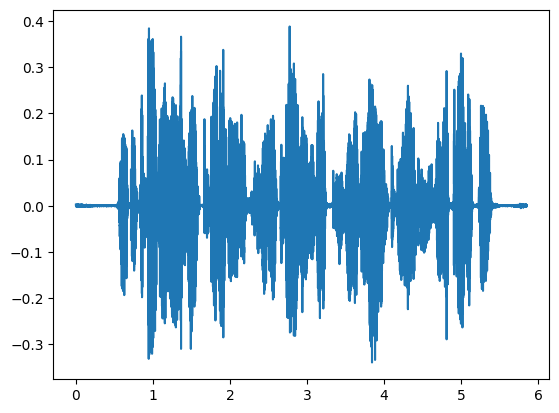

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fs = 1/samplerate
duration = signal.shape[0] *fs
time = np.arange(stop=duration,step=fs)
plt.plot(time,signal)

Compute and display the stft

Spectrogram shape : (1025, 183)


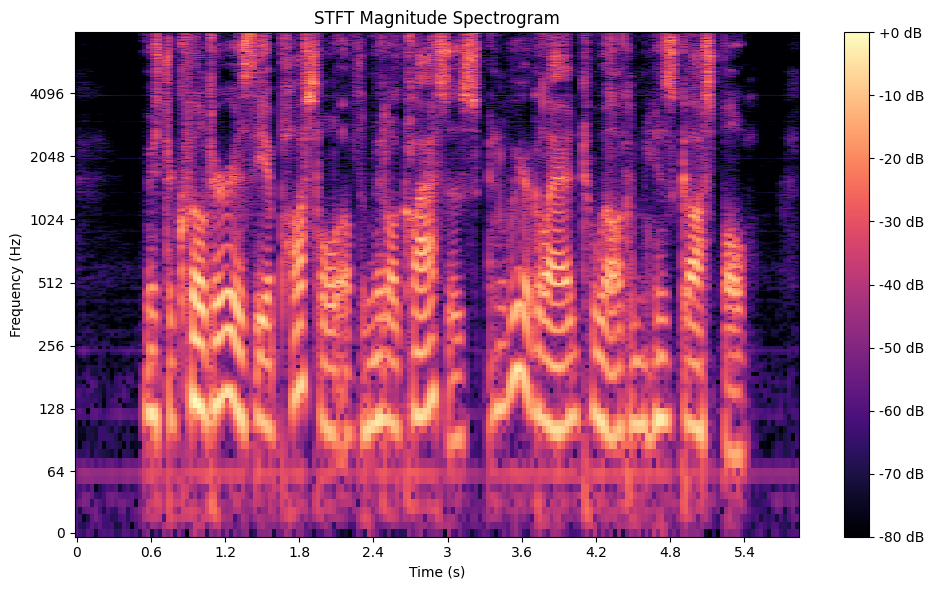

In [38]:
from helpers import plotSpectrogram
import librosa

n_fft = 2048
hop_length = n_fft // 4
stft_signal = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
print(f"Spectrogram shape : {stft_signal.shape}")
plotSpectrogram(stft_signal, samplerate, hop_length)


Can we correctly reconstruct the audio from the stft using the inverse stft ?

Mean Squared Error : 1.976598751829496e-34


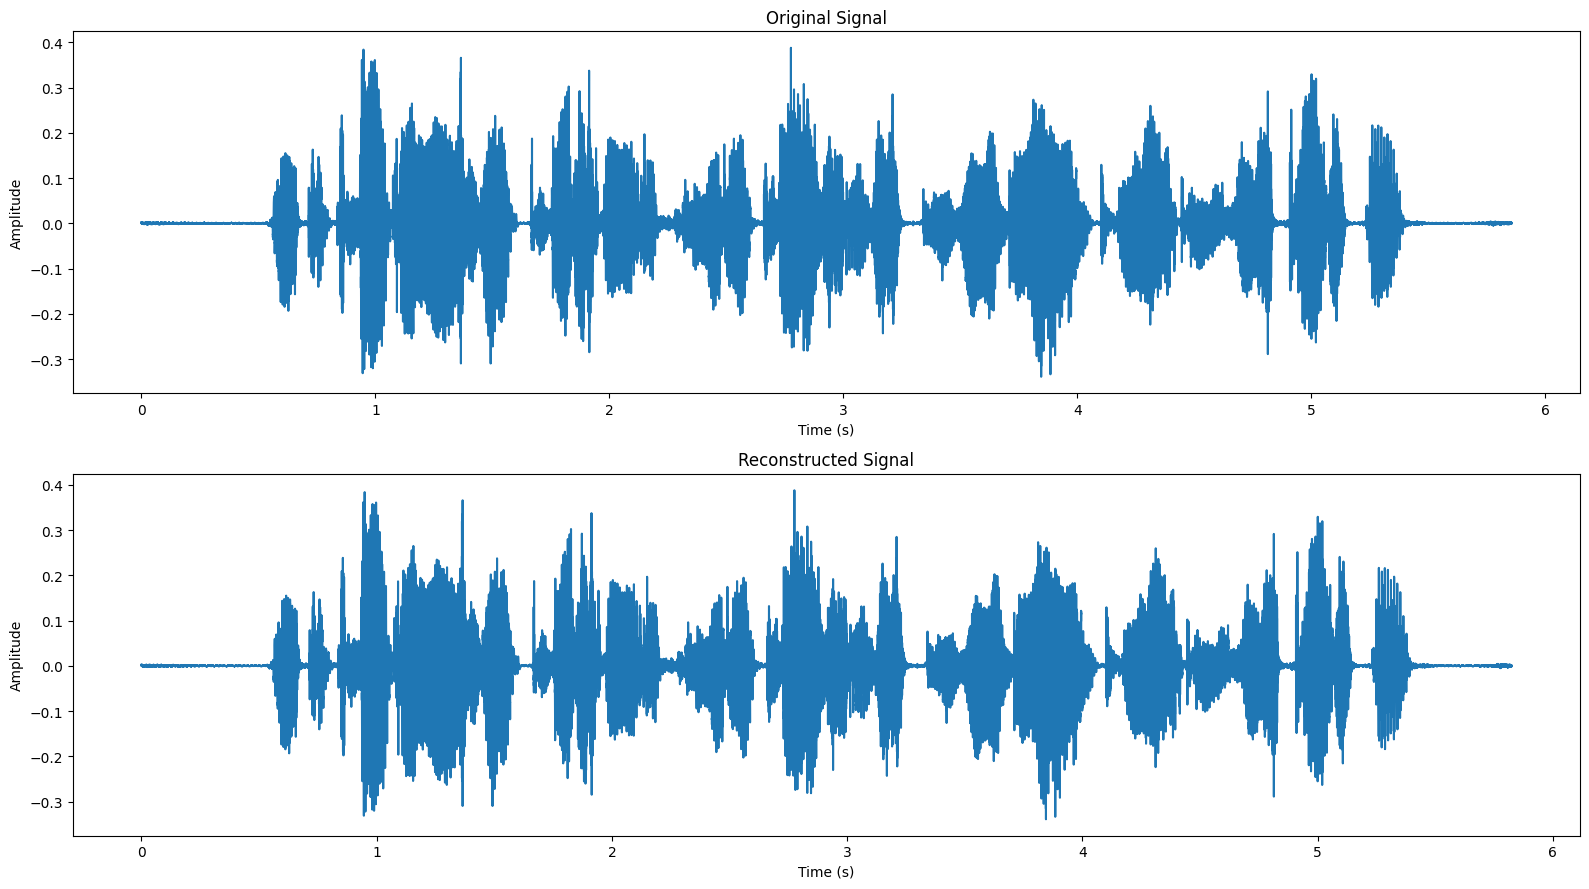

In [39]:
magnitude = np.abs(stft_signal)
phase = np.angle(stft_signal)
stft_reconstructed = magnitude * np.exp(1j*phase)
signal_reconstructed = librosa.istft(stft_signal, hop_length=hop_length)

# Calculate the mean squared error
mse = np.mean((signal[:len(signal_reconstructed)] - signal_reconstructed) ** 2)
print(f"Mean Squared Error : {mse}")

plt.figure(figsize=(16, 9))

# Original signal
plt.subplot(2, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Reconstructed signal
plt.subplot(2, 1, 2)
plt.plot(time[:len(signal_reconstructed)], signal_reconstructed)
plt.title('Reconstructed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

